In [1]:
# Load in the packages
import numpy as np
import folktables
from folktables import ACSDataSource, ACSIncome

import os
import sys
import copy
sys.path.append('..')
import random
import FairCertModule
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms
from FullyConnected import FullyConnected
import pytorch_lightning as pl

# Set random seeds
SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

dataset = "Folk"
if(dataset == "Coverage"):
    TEST_EPSILON = 0.15
else:
    TEST_EPSILON = 0.05   


In [2]:
# Data loaders
import folk_utils
X_train, X_test, X_val, y_train, y_test, y_val, lp_epsilon, sr_epsilon = folk_utils.get_dataset(dataset)
f_epsilon = lp_epsilon

/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


In [3]:
# Load in the trained models

MODEL_STATE  = 'CA'
MODEL_YEAR   = '2015'
MODEL_WIDTH  = '256'
MODEL_METRIC = 'LP'

sgd_id = "SGD" 
pgd_id = "FAIR-PGD" 
ibp_id = "FAIR-IBP" 
glob_id = "FAIR-DRO"
ibpg_id = "FAIR-IBPG"

def load_model_from_id(model_id, dataset, width=MODEL_WIDTH):
    model = FullyConnected(hidden_lay=2, hidden_dim=256, dataset=dataset)
    ckpt = torch.load("%sModels/%s.ckpt"%(dataset, model_id))
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    checkpoint = torch.load("%sModels/%s.ckpt"%(dataset, model_id))
    model.load_state_dict(torch.load('%sModels/%s.pt'%(dataset, model_id)))
    return model

sgd_model = load_model_from_id(sgd_id, dataset)
pgd_model = load_model_from_id(pgd_id, dataset)
ibp_model = load_model_from_id(ibp_id, dataset)
glob_model = load_model_from_id(glob_id, dataset)
ibpg_model = load_model_from_id(ibpg_id, dataset)

In [4]:
# Define evaluation functions
from folk_utils import evaluate_accuracy, evaluate_delta_PGD, evaluate_delta_IBP
# from folk_utils import certify_dist_IBP, certify_dist_PGD


In [5]:
# Evaluate accuracy, lower, and upper bounds (in-dist)
sgd_acc = evaluate_accuracy(sgd_model, X_test, y_test)
pgd_acc = evaluate_accuracy(pgd_model, X_test, y_test)
ibp_acc = evaluate_accuracy(ibp_model, X_test, y_test)
glob_acc = evaluate_accuracy(glob_model, X_test, y_test) 
ibpg_acc = evaluate_accuracy(ibpg_model, X_test, y_test)

[tensor(0.8203), tensor(0.7822), tensor(0.7715), tensor(0.7531), tensor(0.7152)]


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
  del sys.path[0]


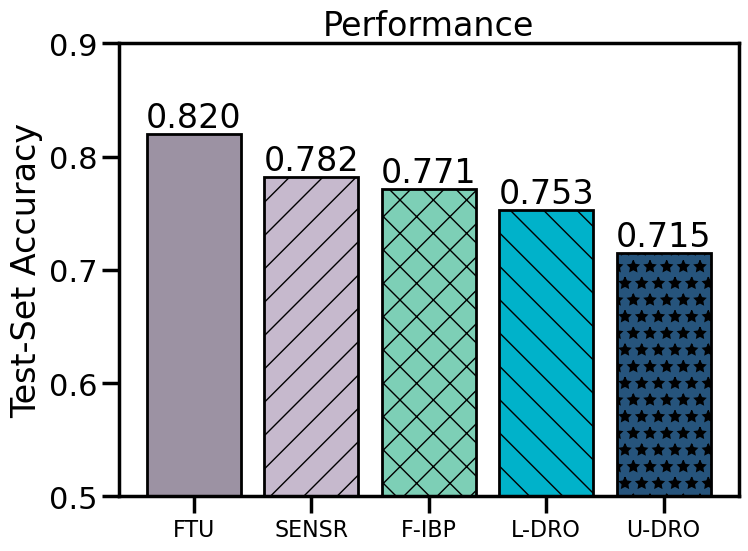

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')


vals = [sgd_acc, pgd_acc, ibp_acc, glob_acc, ibpg_acc]
print(vals)
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

rects_1 = plt.bar(x=range(len(vals)), height=vals, edgecolor='k', 
                  color=["#9C92A3","#C6B9CD", "#7DCFB6", "#00B2CA", "#26547C"],
                  hatch=[' ', '/', 'x', '\\', '*']) 

ax.bar_label(rects_1, labels=['%.3f'%e if e != 1 else '%.3f'%e for e in vals], 
                 padding=0, fontsize=24,  rotation=0, color='k', )

plt.ylim((0.5, 0.9))
#ax.set_xticks(range(len(vals)), ['FTU', 'SENSR', 'F-IBP', 'F-GLOB'])
ax.set_xticks(range(len(vals)), ['FTU', 'SENSR', 'F-IBP', 'L-DRO', 'U-DRO'], fontsize=16)
#ax.set_xticks([], [])
plt.ylabel('Test-Set Accuracy')
plt.title('Performance')
plt.show()

In [7]:
# Evaluate the ood accuracy, lower, and upper bounds
f_epsilon = torch.Tensor(f_epsilon)
sgd_pgd = evaluate_delta_PGD(sgd_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2, iterations=25)
pgd_pgd = evaluate_delta_PGD(pgd_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2, iterations=25)
ibp_pgd = evaluate_delta_PGD(ibp_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2, iterations=25)
glob_pgd = evaluate_delta_PGD(glob_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2, iterations=25)
ibpg_pgd = evaluate_delta_PGD(ibpg_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2, iterations=25)

/Users/matthewwicker/Desktop/Development/CertificationOfDistributionalIF/Folktables/folk_utils.py:253: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(model(inp)).detach().numpy()
/Users/matthewwicker/Desktop/Development/CertificationOfDistributionalIF/Folktables/folk_utils.py:255: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_adv = F.softmax(model(x_adv)).detach().numpy()


[0.3160276, 0.0047394303, 0.029688027, 0.010473936, 0.0011523585]


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
  del sys.path[0]


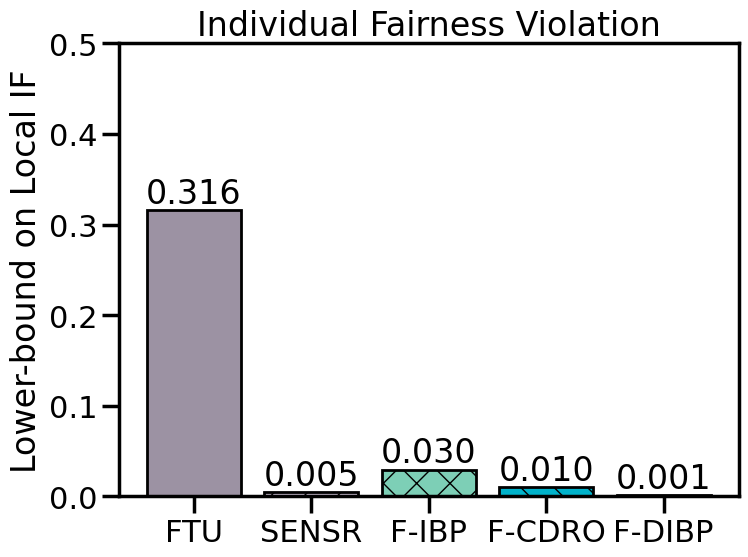

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')


vals = [sgd_pgd, pgd_pgd, ibp_pgd, glob_pgd, ibpg_pgd]
print(vals)
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

rects_1 = plt.bar(x=range(len(vals)), height=vals, edgecolor='k', 
                  color=["#9C92A3","#C6B9CD", "#7DCFB6", "#00B2CA", "#26547C"],
                  hatch=[' ', '/', 'x', '\\', '*']) 

ax.bar_label(rects_1, labels=['%.3f'%e if e != 1 else '%.3f'%e for e in vals], 
                 padding=0, fontsize=24,  rotation=0, color='k', )

plt.ylim((0.0, 0.5))
ax.set_xticks(range(len(vals)), ['FTU', 'SENSR', 'F-IBP', 'F-CDRO', 'F-DIBP'])
#ax.set_xticks([], [])
plt.ylabel('Lower-bound on Local IF')
plt.title('Individual Fairness Violation')
plt.show()

In [9]:
# Evaluate the ood accuracy, lower, and upper bounds
f_epsilon = torch.Tensor(f_epsilon)
sgd_ibp = evaluate_delta_IBP(sgd_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2)
pgd_ibp = evaluate_delta_IBP(pgd_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2)
ibp_ibp = evaluate_delta_IBP(ibp_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2)
glob_ibp = evaluate_delta_IBP(glob_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2)
ibpg_ibp = evaluate_delta_IBP(ibpg_model, X_test, y_test, f_epsilon, TEST_EPSILON, 2)

[0.9996197, 0.8950042, 0.076348215, 0.04299348, 0.0023301565]


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
  del sys.path[0]


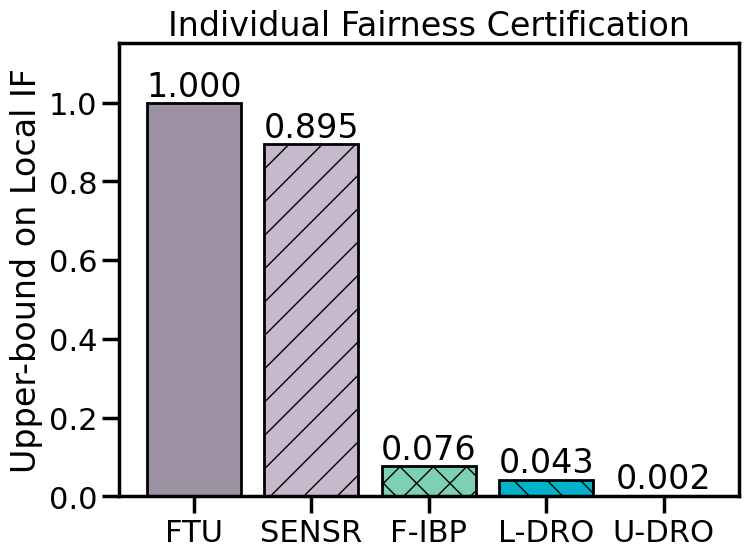

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')


vals = [sgd_ibp, pgd_ibp, ibp_ibp, glob_ibp, ibpg_ibp]
print(vals)
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

rects_1 = plt.bar(x=range(len(vals)), height=vals, edgecolor='k', 
                  color=["#9C92A3","#C6B9CD", "#7DCFB6", "#00B2CA", "#26547C"],
                  hatch=[' ', '/', 'x', '\\', '*']) 

ax.bar_label(rects_1, labels=['%.3f'%e if e != 1 else '%.3f'%e for e in vals], 
                 padding=0, fontsize=24,  rotation=0, color='k', )

plt.ylim((0.0, 1.15))
ax.set_xticks(range(len(vals)), ['FTU', 'SENSR', 'F-IBP', 'L-DRO', 'U-DRO'])
#ax.set_xticks([], [])
plt.ylabel('Upper-bound on Local IF')
plt.title('Individual Fairness Certification')
plt.show()

In [29]:
from folk_utils import compute_DIF_certification, compute_DIF_falsification
epsilons = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
ibps_l = []
dros_l = []
pgds_l = []
ibgs_l = []
sgds_l = []
ibps_u = []
dros_u = []
pgds_u = []
ibgs_u = []
sgds_u = []
for eps in epsilons:
    print(eps)
    sgd_lower = compute_DIF_falsification(pgd_model, f_epsilon, eps, 0.025, X_test, y_test, N=1000, iters=500, rettrend=False)  
    sgd_upper = compute_DIF_certification(pgd_model, f_epsilon, eps, 0.025, X_test, y_test, N=1000, iters=500, rettrend=False) 
    #pgds_l.append(pgd_lower.detach().numpy()); pgds_u.append(pgd_upper.detach().numpy())
    sgds_l.append(sgd_lower); sgds_u.append(sgd_upper)
    
    
    pgd_lower = compute_DIF_falsification(pgd_model, f_epsilon, eps, 0.025, X_test, y_test, N=1000, iters=500, rettrend=False)  
    pgd_upper = compute_DIF_certification(pgd_model, f_epsilon, eps, 0.025, X_test, y_test, N=1000, iters=500, rettrend=False) 
    #pgds_l.append(pgd_lower.detach().numpy()); pgds_u.append(pgd_upper.detach().numpy())
    pgds_l.append(pgd_lower); pgds_u.append(pgd_upper)
    
    ibp_lower = compute_DIF_falsification(ibp_model, f_epsilon, eps, 0.025, X_test, y_test, N=1000, iters=500, rettrend=False)  
    ibp_upper = compute_DIF_certification(ibp_model, f_epsilon, eps, 0.025, X_test, y_test, N=1000, iters=500, rettrend=False) 
    ibps_l.append(ibp_lower); ibps_u.append(ibp_upper)
    
    dro_lower = compute_DIF_falsification(glob_model, f_epsilon, eps, 0.025, X_test, y_test, N=1000, iters=500, rettrend=False)  
    dro_upper = compute_DIF_certification(glob_model, f_epsilon, eps, 0.025, X_test, y_test, N=1000, iters=500, rettrend=False)
    dros_l.append(dro_lower); dros_u.append(dro_upper)
    
    ibg_lower = compute_DIF_falsification(ibpg_model, f_epsilon, eps, 0.025, X_test, y_test, N=1000, iters=500, rettrend=False)  
    ibg_upper = compute_DIF_certification(ibpg_model, f_epsilon, eps, 0.025, X_test, y_test, N=1000, iters=500, rettrend=False)
    ibgs_l.append(ibg_lower); ibgs_u.append(ibg_upper)
    

0.005


100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 55.63it/s]


0.01


100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 56.20it/s]


0.02


100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 56.23it/s]


0.03


100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 57.66it/s]


0.04


100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 57.39it/s]


0.05


100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 57.21it/s]


0.06


100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 57.90it/s]


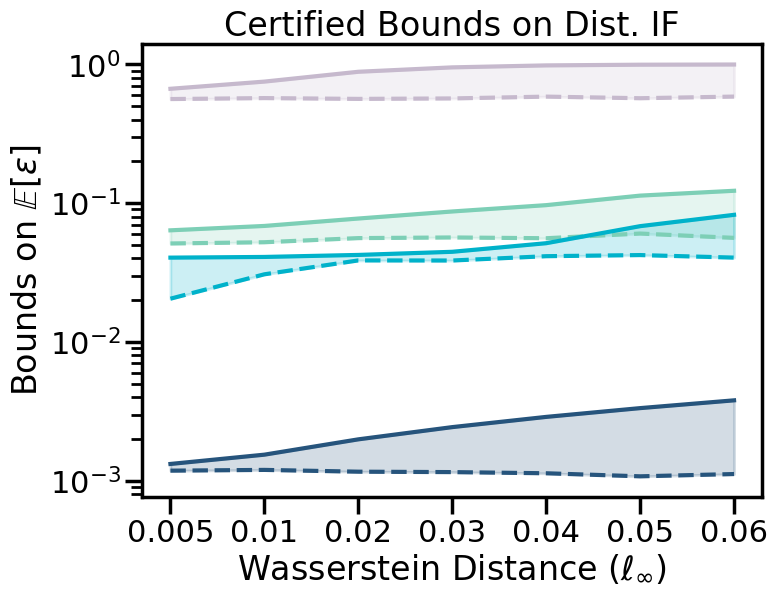

In [30]:
#"#C6B9CD", "#7DCFB6", "#00B2CA"

def process(arr):
    new = []
    for i in arr:
        try:
            new.append(i.detach().numpy())
        except:
            new.append(float(i))
    return new
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

plt.plot(process(pgds_u), c="#C6B9CD")
plt.plot(process(pgds_l), c="#C6B9CD", linestyle='--')
plt.fill_between(x=range(len(pgds_l)), y1=process(pgds_l), y2=process(pgds_u), color="#C6B9CD", alpha=0.2)

plt.plot(process(ibps_u), c="#7DCFB6")
plt.plot(process(ibps_l), c="#7DCFB6", linestyle='--')
plt.fill_between(x=range(len(pgds_l)), y1=process(ibps_l), y2=process(ibps_u), color="#7DCFB6", alpha=0.2)

plt.plot(process(dros_u), c="#00B2CA")
plt.plot(process(dros_l), c="#00B2CA", linestyle='--')
plt.fill_between(x=range(len(pgds_l)), y1=process(dros_l), y2=process(dros_u), color="#00B2CA", alpha=0.2)

plt.plot(process(ibgs_u), c="#26547C")
plt.plot(process(ibgs_l), c="#26547C", linestyle='--')
plt.fill_between(x=range(len(pgds_l)), y1=process(ibgs_l), y2=process(ibgs_u), color="#26547C", alpha=0.2)


ax.set_xticks(range(len(epsilons)))
ax.set_xticklabels(epsilons)
plt.title("Certified Bounds on Dist. IF")
plt.ylabel(r"Bounds on $\mathbb{E}[\epsilon]$")
plt.xlabel(r'Wasserstein Distance ($\ell_\infty$)')
plt.semilogy()
plt.show()


In [19]:
ibp_l, ibp_trend = compute_DIF_falsification(ibp_model, f_epsilon, eps, 0.02, X_test, y_test, N=1000, iters=700, rettrend=True) 

ibp_u, ibp_trend = compute_DIF_certification(ibp_model, f_epsilon, eps, 0.02, X_test, y_test, N=1000, iters=200, rettrend=True) 

print(ibp_l.detach().numpy())
print(ibp_u.detach().numpy())



100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 58.50it/s]


ValueError: too many values to unpack (expected 2)

In [22]:
from FairCertModule import *
from tqdm import trange

sgd_dro = compute_DIF_certification(sgd_model, f_epsilon, 0.025, 0.025, X_test, y_test, N=1000, iters=1000, rettrend=False) 
pgd_dro = compute_DIF_certification(pgd_model, f_epsilon, 0.025, 0.025, X_test, y_test, N=1000, iters=1000, rettrend=False)   
ibp_dro = compute_DIF_certification(ibp_model, f_epsilon, 0.025, 0.025, X_test, y_test, N=1000, iters=1000, rettrend=False)  
glob_dro = compute_DIF_certification(glob_model, f_epsilon, 0.025, 0.025, X_test, y_test, N=1000, iters=100, rettrend=False)
ibpg_dro = compute_DIF_certification(ibpg_model, f_epsilon, 0.05, 0.025, X_test, y_test, N=1000, iters=1000, rettrend=False)



100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 52.85it/s]


In [23]:
print(sgd_dro)
print(pgd_dro)
print(ibp_dro)
print(glob_dro)
print(ibpg_dro)

0.9997887015342712
0.9277749061584473
0.08289286494255066
0.04311707243323326
0.003369830548763275


In [24]:
# Load in the geographical datasets 

def get_data_states(dataset, year):
    state_X_tests = []; state_y_tests = []
    state_lrs = []; state_srs = []
    year = str(year)
    states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
    for state in states:
        _, X_test, _, _, y_test, _, lp_epsilon, sr_epsilon = folk_utils.get_dataset(dataset, year, state)
        if(X_test.shape[-1] != X_val.shape[-1]):
            continue
        state_X_tests.append(X_test)
        state_y_tests.append(y_test)
        state_lrs.append(lp_epsilon); state_srs.append(sr_epsilon)
    return state_X_tests, state_y_tests

X_test_states, y_test_states = get_data_states(dataset, '2015')


/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: i

/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[N

/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/

In [25]:
sgd_accs = []
pgd_accs = []
ibp_accs = []
glob_accs = []
ibpg_accs = []
for X, y in zip(X_test_states, y_test_states):
    X = torch.Tensor(X)
    y = torch.Tensor(y).type(torch.LongTensor)
    sa = evaluate_accuracy(sgd_model, X, y)
    sgd_accs.append(sa)
    
    pa = evaluate_accuracy(pgd_model, X, y)
    pgd_accs.append(pa)
    
    ia = evaluate_accuracy(ibp_model, X, y)
    ibp_accs.append(ia)
    
    ga = evaluate_accuracy(glob_model, X, y)
    glob_accs.append(ga)
    
    da = evaluate_accuracy(ibpg_model, X, y)
    ibpg_accs.append(da)

In [ ]:
"""
sgd_pgds = []
pgd_pgds = []
ibp_pgds = []
glob_pgds = []
ibpg_pgds = []
for X, y in zip(X_test_states, y_test_states):
    X = torch.Tensor(X)
    y = torch.Tensor(y).type(torch.LongTensor)
    sa = evaluate_delta_PGD(sgd_model, X, y, f_epsilon, TEST_EPSILON, 2, iterations=25)
    sgd_pgds.append(sa)
    
    pa = evaluate_delta_PGD(pgd_model, X, y, f_epsilon, TEST_EPSILON, 2, iterations=25)
    pgd_pgds.append(pa)
    
    ia = evaluate_delta_PGD(ibp_model, X, y, f_epsilon, TEST_EPSILON, 2, iterations=25)
    ibp_pgds.append(ia)
    
    ga = evaluate_delta_PGD(glob_model, X, y, f_epsilon, TEST_EPSILON, 2, iterations=25)
    glob_pgds.append(ga)
    
    da = evaluate_delta_PGD(ibpg_model, X, y, f_epsilon, TEST_EPSILON, 2, iterations=25)
    ibpg_pgds.append(da)
"""

In [26]:
sgd_ibps = []
pgd_ibps = []
ibp_ibps = []
glob_ibps = []
ibpg_ibps = []
for X, y in zip(X_test_states, y_test_states):
    X = torch.Tensor(X)
    y = torch.Tensor(y).type(torch.LongTensor)
    sa = evaluate_delta_IBP(sgd_model, X, y, f_epsilon, TEST_EPSILON, 2)
    sgd_ibps.append(sa)
    
    pa = evaluate_delta_IBP(pgd_model, X, y, f_epsilon, TEST_EPSILON, 2)
    pgd_ibps.append(pa)
    
    ia = evaluate_delta_IBP(ibp_model, X, y, f_epsilon, TEST_EPSILON, 2)
    ibp_ibps.append(ia)
    
    ga = evaluate_delta_IBP(glob_model, X, y, f_epsilon, TEST_EPSILON, 2)
    glob_ibps.append(ga)
    
    da = evaluate_delta_IBP(ibpg_model, X, y, f_epsilon, TEST_EPSILON, 2)
    ibpg_ibps.append(da)

[]

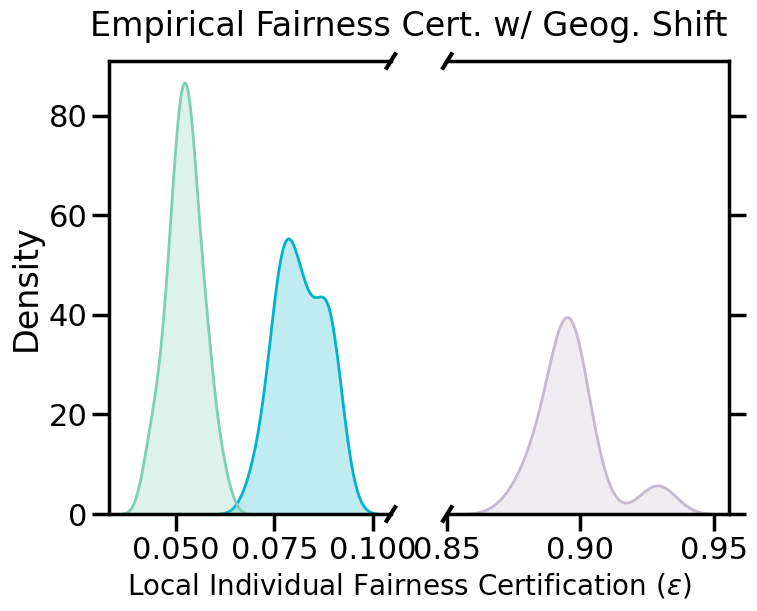

In [27]:
#"#C6B9CD", "#7DCFB6", "#00B2CA"

f,(ax,ax2) = plt.subplots(1,2,sharey=True, figsize=(8,6), dpi=100)

# plot the same data on both axes
#ax.plot(x, y)
sns.kdeplot(ibp_ibps, ax=ax, fill=True, color="#00B2CA")
sns.kdeplot(glob_ibps, ax=ax, fill=True, color="#7DCFB6")
sns.kdeplot(pgd_ibps, ax=ax2, fill=True, color="#C6B9CD")



# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
#ax.yaxis.tick_left()
#ax.tick_params(labelright='off')
ax2.yaxis.tick_right()
#ax2.set_yticklabels([])

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((1-d,1+d),(1-d,1+d), **kwargs)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)

#ax2.set_yticks([])
plt.suptitle('Empirical Fairness Cert. w/ Geog. Shift', fontsize=24, y=0.965)
f.supxlabel('Local Individual Fairness Certification ($\epsilon$)', fontsize=20, y=-0.02)
plt.plot()

In [ ]:
asdf = asdf 

In [ ]:
# Compute distributional robustness upper and lower bounds
from folk_utils import compute_DIF_certification, compute_DIF_falsification
from FairCertModule import *
from tqdm import trange

sgd_dro, ibp_trend = compute_DIF_certification(sgd_model, f_epsilon, 0.025, 0.025, X_test, y_test, N=1000, iters=100, rettrend=True) 
pgd_dro, ibp_trend = compute_DIF_certification(pgd_model, f_epsilon, 0.025, 0.025, X_test, y_test, N=1000, iters=100, rettrend=True)   
ibp_dro, ibp_trend = compute_DIF_certification(ibp_model, f_epsilon, 0.025, 0.025, X_test, y_test, N=1000, iters=100, rettrend=True)  
glob_dro, glob_trend = compute_DIF_certification(glob_model, f_epsilon, 0.025, 0.025, X_test, y_test, N=1000, iters=100, rettrend=True)
ibpg_dro, glob_trend = compute_DIF_certification(ibpg_model, f_epsilon, 0.15, 0.025, X_test, y_test, N=1000, iters=100, rettrend=True)



In [ ]:
print(sgd_dro)
print(pgd_dro)
print(ibp_dro)
print(glob_dro)
print(ibpg_dro)

In [ ]:
sgd_dro, ibp_trend = compute_DIF_falsification(sgd_model, f_epsilon, 0.05, 0.025, X_test, y_test, N=1000, iters=100, rettrend=True) 
pgd_dro, ibp_trend = compute_DIF_falsification(pgd_model, f_epsilon, 0.05, 0.025, X_test, y_test, N=1000, iters=100, rettrend=True)   
ibp_dro, ibp_trend = compute_DIF_falsification(ibp_model, f_epsilon, 0.05, 0.025, X_test, y_test, N=1000, iters=100, rettrend=True)  
glob_dro, glob_trend = compute_DIF_falsification(glob_model, f_epsilon, 0.05, 0.025, X_test, y_test, N=1000, iters=100, rettrend=True)
ibpg_dro, glob_trend = compute_DIF_falsification(ibpg_model, f_epsilon, 0.15, 0.025, X_test, y_test, N=1000, iters=100, rettrend=True)


In [ ]:
print(sgd_dro)
print(pgd_dro)
print(ibp_dro)
print(glob_dro)
print(ibpg_dro)